In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt

import os
import random

import numpy as np
import torch
import scipy.io

from experiment import lesion
from experiment import mRNN
from experiment import michaels_load
from experiment import stim
from experiment import utils

#CUDA = torch.device(0)
CUDA = None


In [2]:
mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       cuda=CUDA)

In [3]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(),
    cuda=CUDA, with_label=True)

# Dataset items are:
#   (michaels network input, trial end indicator, trial len (scalar),
#    target output, class label)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

<ipython-input-4-43de8d988920>:5: RuntimeWarning: invalid value encountered in true_divide
  J_bin = J / J


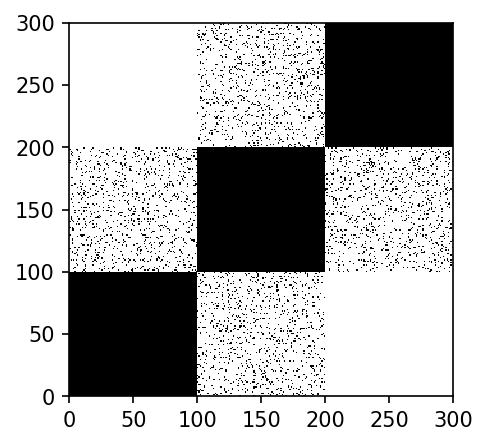

In [4]:
# Block matrix graph of the Michaels connectivity matrix
plt.figure(figsize=(3.3, 3.3), dpi=150)
J = mike.J.cpu().detach().numpy()

J_bin = J / J

plt.pcolormesh(J_bin, cmap=matplotlib.cm.gray)
plt.savefig('paper/figs/mRNN_J.png', format='png', dpi=150)
plt.show()

In [5]:
# The whole dataset
all_data = next(iter(dataloader))

din = all_data[0]
dout = all_data[-2]
trial_end = all_data[1]

batch_size = din.shape[0]
trial_len = din.shape[1]
out_dim = dout.shape[-1]


# Batch idx, time, feature
print("Input shape:", din.shape)

# Batch idx, time, muscle idx
print("Output shape:", dout.shape)

Input shape: torch.Size([502, 341, 21])
Output shape: torch.Size([502, 341, 50])


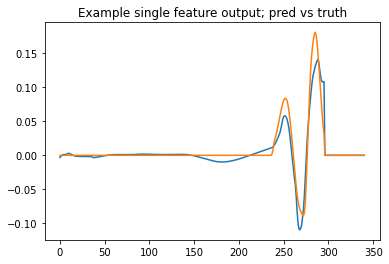

In [6]:
# Ground truth vs. un-lesioned network

preds = torch.empty(batch_size, trial_len, out_dim)
if CUDA:
    preds = preds.cuda(CUDA)

mike.reset()

for tidx in range(trial_len):
    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    preds[:, tidx, :] = mike_out

healthy_preds = utils.trunc_to_trial_end(preds, trial_end)

bidx = random.randrange(batch_size)
fidx = random.randrange(out_dim)
plt.plot(healthy_preds[bidx,:,fidx].detach().numpy())
plt.plot(dout[bidx, :, fidx].detach().numpy())
plt.title("Example single feature output; pred vs truth")
plt.show()

In [7]:
# Now do the same thing again, but perturbe the cell activations at
#  time t=<something>.
# Our perturbance will be applied to N random cells in the "M1" portion
#     of the network.

# This is the time step when we will perturbe the network
tidx_perturbe = 125
# Number of M1 cells we will perturbe. This is out of a maximum of 100.
num_perturbed_cells = 10

# Magnitude of process disturbance. Since we are examining the length of
#  the disturbance, the magnitude we choose isn't crucial here. Let's
#  just scale it to the data somehow.
noise_magnitude = dout.abs().max() * 1.9

num_samples = 1000

# We pick one single trial to do this on
sample_idx = random.choice(range(batch_size))
print("Sample idx:", sample_idx)
sample_din = din[sample_idx, :, :].unsqueeze(dim=0).repeat(num_samples, 1, 1)
sample_trial_end = trial_end[sample_idx, :, :].unsqueeze(dim=0).repeat(num_samples, 1, 1)

perturbed_preds = torch.empty(num_samples, dout.shape[1], dout.shape[2])
   
num_noise = num_perturbed_cells

noise = torch.zeros(num_samples, mike.num_neurons)
for sidx in range(num_samples):
    # The first 100 cells are analogue to M1; i.e. this is the output end of the network
    cell_idxs = random.choices(range(100), k=num_perturbed_cells)
    for cidx in cell_idxs:
        noise[sidx, cidx] = noise_magnitude
                              
preds = torch.empty(num_samples, trial_len, out_dim)
if CUDA:
    preds = preds.cuda(CUDA)

mike.reset()

for tidx in range(trial_len):
    if tidx == tidx_perturbe:         
        mike.x += noise
        
    mike_in = sample_din[:, tidx, :].T
    mike_out = mike(mike_in)
    preds[:, tidx, :] = mike_out

perturbed_preds = utils.trunc_to_trial_end(preds, sample_trial_end).detach().numpy()

Sample idx: 189


621 307 7


<Figure size 432x288 with 0 Axes>

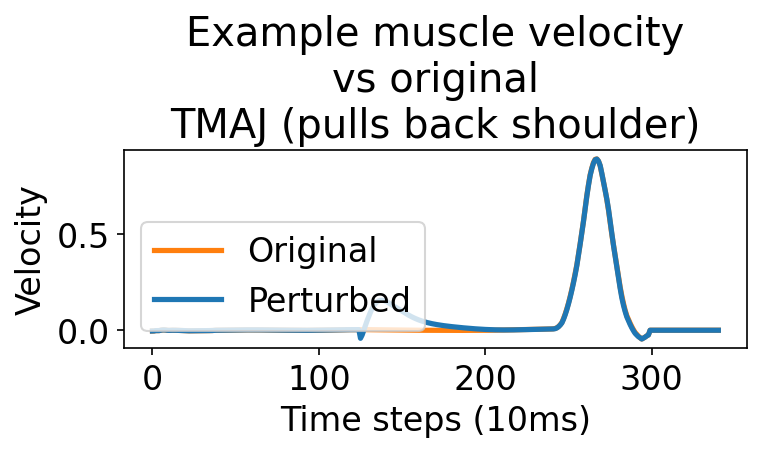

In [10]:
# Display TMAJ example
sidx = random.randrange(num_samples)
bidx = random.randrange(batch_size)
#fidx = random.randrange(out_dim)
fidx = 7
print(sidx, bidx, fidx)

plt.rc('font', size=16)
plt.subplots_adjust(wspace=0.25, left=0.20, right=1.20, bottom=0.15, top=1.15)
plt.figure(figsize=(5.5, 3.3), dpi=150)


plt.plot(healthy_preds[sample_idx, :, fidx].detach().numpy(), linewidth=2.5, label="Original", color="tab:orange")
plt.plot(perturbed_preds[sidx, :, fidx], linewidth=2.5, label="Perturbed", color="tab:blue")
plt.title("Example muscle velocity\nvs original\nTMAJ (pulls back shoulder)")
plt.xlabel("Time steps (10ms)")
plt.ylabel("Velocity")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig('paper/figs/perturbe_single_tmaj.pdf', format='pdf', dpi=150)
plt.show()

<Figure size 432x288 with 0 Axes>

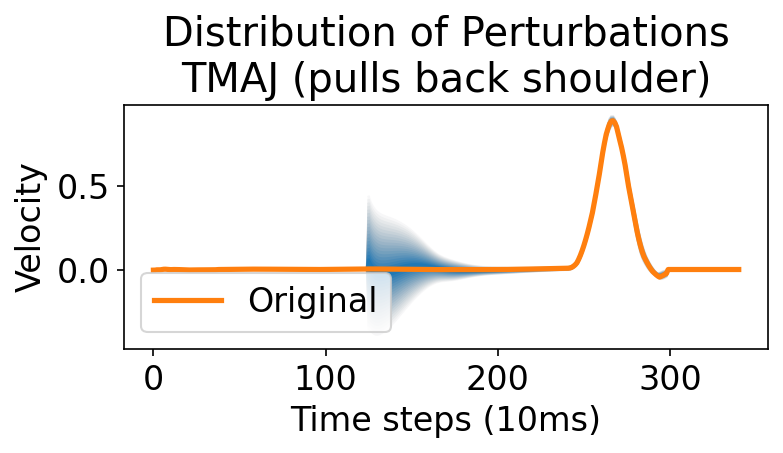

In [11]:
# Show graphs for a single output feature / muscle
max_plot_stdev = 2
inc_plot_stdev = 0.1
fidx = 7

means = np.mean(perturbed_preds[:, :, fidx], axis=0)
stdevs = np.std(perturbed_preds[:, :, fidx], axis=0)

# Color of center of dist, in hsv
base_color = (0.568, 1.1*0.828, 0.706)

# The original / unpurturbed curve

plt.rc('font', size=16)
plt.subplots_adjust(wspace=0.25, left=0.20, right=1.20, bottom=0.15, top=1.15)
plt.figure(figsize=(5.5, 3.3), dpi=150)

cur_stdev = max_plot_stdev
while cur_stdev > 0.0:
    x_top = []
    y_top = []
    x_bottom = []
    y_bottom = []
    for tidx in range(trial_len):
        x_top.append(tidx)
        x_bottom.append(tidx)
        
        y_top.append(means[tidx] + stdevs[tidx] * cur_stdev)
        y_bottom.append(means[tidx] - stdevs[tidx] * cur_stdev)
    
    x_bottom.reverse()
    y_bottom.reverse()
    
    x = x_top + x_bottom
    y = y_top + y_bottom
    
    color_mod = cur_stdev / max_plot_stdev
    
    color_hsv = (base_color[0], base_color[1] * (1 - color_mod)**2, base_color[2] + (1 - base_color[2]) * color_mod**2)
    plt.fill(x, y, color=matplotlib.colors.hsv_to_rgb(color_hsv))
    
    cur_stdev -= inc_plot_stdev
        
plt.plot(healthy_preds[sample_idx, :, fidx].detach().numpy(), linewidth=2.5, label="Original", color="tab:orange")
plt.title("Distribution of Perturbations\nTMAJ (pulls back shoulder)")
plt.xlabel("Time steps (10ms)")
plt.ylabel("Velocity")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig('paper/figs/perturbe_dist_tmaj.pdf', format='pdf', dpi=150)
plt.show()

681 174 45


<Figure size 432x288 with 0 Axes>

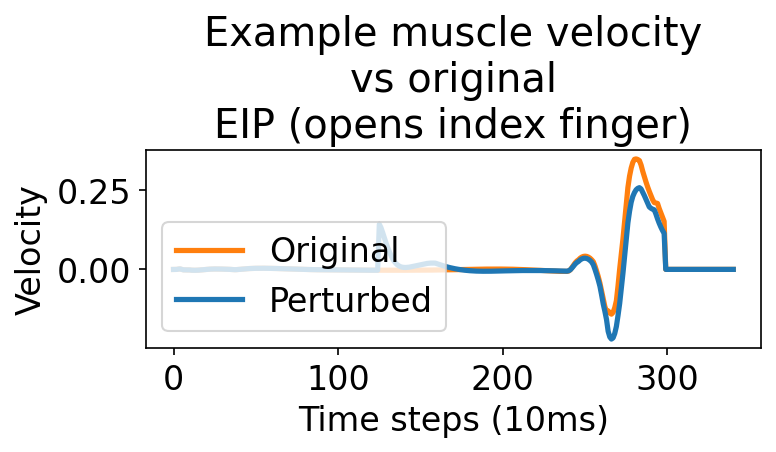

In [12]:
# Display EIP example
sidx = random.randrange(num_samples)
bidx = random.randrange(batch_size)
#fidx = random.randrange(out_dim)
fidx = 45
print(sidx, bidx, fidx)

plt.rc('font', size=16)
plt.subplots_adjust(wspace=0.25, left=0.20, right=1.20, bottom=0.15, top=1.15)
plt.figure(figsize=(5.5, 3.3), dpi=150)


plt.plot(healthy_preds[sample_idx, :, fidx].detach().numpy(), linewidth=2.5, label="Original", color="tab:orange")
plt.plot(perturbed_preds[sidx, :, fidx], linewidth=2.5, label="Perturbed", color="tab:blue")
plt.title("Example muscle velocity\nvs original\nEIP (opens index finger)")
plt.xlabel("Time steps (10ms)")
plt.ylabel("Velocity")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig('paper/figs/perturbe_single_eip.pdf', format='pdf', dpi=150)
plt.show()

<Figure size 432x288 with 0 Axes>

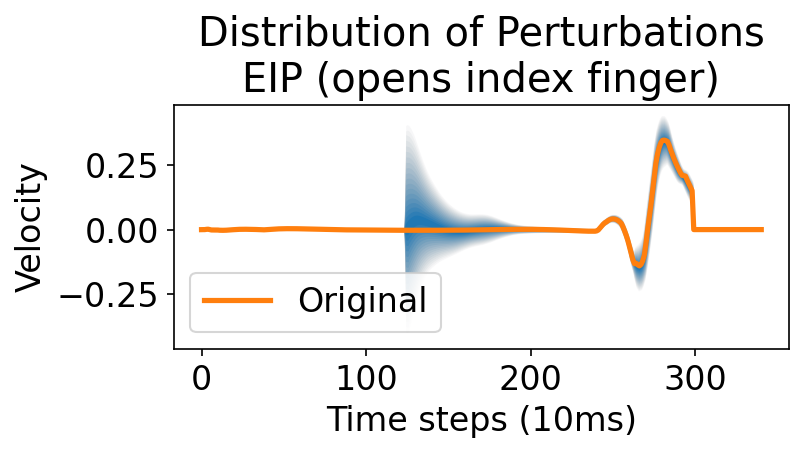

In [13]:
# Show graphs for a single output feature / muscle
max_plot_stdev = 2
inc_plot_stdev = 0.1
fidx = 45

means = np.mean(perturbed_preds[:, :, fidx], axis=0)
stdevs = np.std(perturbed_preds[:, :, fidx], axis=0)

# Color of center of dist, in hsv
base_color = (0.568, 1.1*0.828, 0.706)

# The original / unpurturbed curve

plt.rc('font', size=16)
plt.subplots_adjust(wspace=0.25, left=0.20, right=1.20, bottom=0.15, top=1.15)
plt.figure(figsize=(5.5, 3.3), dpi=150)

cur_stdev = max_plot_stdev
while cur_stdev > 0.0:
    x_top = []
    y_top = []
    x_bottom = []
    y_bottom = []
    for tidx in range(trial_len):
        x_top.append(tidx)
        x_bottom.append(tidx)
        
        y_top.append(means[tidx] + stdevs[tidx] * cur_stdev)
        y_bottom.append(means[tidx] - stdevs[tidx] * cur_stdev)
    
    x_bottom.reverse()
    y_bottom.reverse()
    
    x = x_top + x_bottom
    y = y_top + y_bottom
    
    color_mod = cur_stdev / max_plot_stdev
    
    color_hsv = (base_color[0], base_color[1] * (1 - color_mod)**2, base_color[2] + (1 - base_color[2]) * color_mod**2)
    plt.fill(x, y, color=matplotlib.colors.hsv_to_rgb(color_hsv))
    
    cur_stdev -= inc_plot_stdev
        
plt.plot(healthy_preds[sample_idx, :, fidx].detach().numpy(), linewidth=2.5, label="Original", color="tab:orange")
plt.title("Distribution of Perturbations\nEIP (opens index finger)")
plt.xlabel("Time steps (10ms)")
plt.ylabel("Velocity")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig('paper/figs/perturbe_dist_eip.pdf', format='pdf', dpi=150)
plt.show()

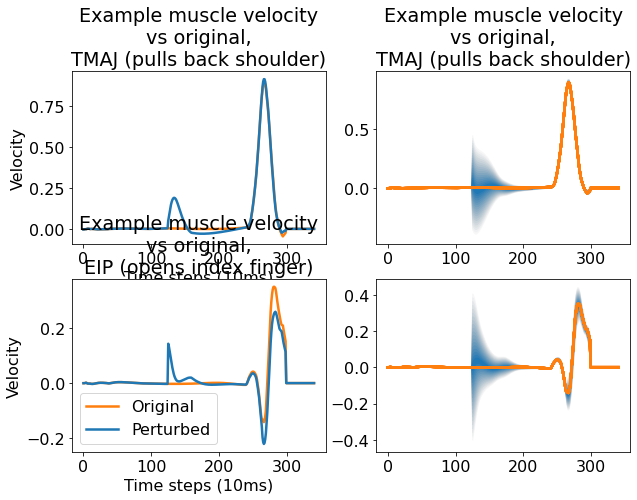

In [14]:
# TODO: lesion earlier during image encoding
# TODO: subfig with same two muscles as in analyze_lesions:  7, 45

def plot_dist(fidx, axs, max_plot_stdev=2):
    means = np.mean(perturbed_preds[:, :, fidx], axis=0)
    stdevs = np.std(perturbed_preds[:, :, fidx], axis=0)
    
    cur_stdev = max_plot_stdev
    while cur_stdev > 0.0:
        x_top = []
        y_top = []
        x_bottom = []
        y_bottom = []
        for tidx in range(trial_len):
            x_top.append(tidx)
            x_bottom.append(tidx)

            y_top.append(means[tidx] + stdevs[tidx] * cur_stdev)
            y_bottom.append(means[tidx] - stdevs[tidx] * cur_stdev)

        x_bottom.reverse()
        y_bottom.reverse()

        x = x_top + x_bottom
        y = y_top + y_bottom

        color_mod = cur_stdev / max_plot_stdev

        color_hsv = (base_color[0], base_color[1] * (1 - color_mod)**2, base_color[2] + (1 - base_color[2]) * color_mod**2)
        axs.fill(x, y, color=matplotlib.colors.hsv_to_rgb(color_hsv))
        axs.plot(healthy_preds[sample_idx, :, fidx].detach().numpy(), linewidth=2.5, label="Original", color="tab:orange")

        cur_stdev -= inc_plot_stdev
        
def plot_single(fidx, axs, show_legend=True):
    axs.plot(healthy_preds[sample_idx, :, fidx].detach().numpy(), linewidth=2.5,
             label="Original", color="tab:orange")
    axs.plot(perturbed_preds[sidx, :, fidx], linewidth=2.5, label="Perturbed",
             color="tab:blue")
    axs.set_xlabel("Time steps (10ms)")
    axs.set_ylabel("Velocity")
    
    if show_legend:
        axs.legend(loc="lower left")

    
fig, axs = plt.subplots(2,2, figsize=(10, 7))

plot_single(7, axs[0, 0], show_legend=False)
axs[0, 0].set_title("Example muscle velocity\nvs original,\nTMAJ (pulls back shoulder)")

plot_single(45, axs[1, 0])
axs[1, 0].set_title("Example muscle velocity\nvs original,\nEIP (opens index finger)")

plot_dist(7, axs[0, 1])
axs[0, 1].set_title("Example muscle velocity\nvs original,\nTMAJ (pulls back shoulder)")

plot_dist(45, axs[1, 1])

